# Decision Trees and Interpretability

In [1]:
import pandas as pd
import numpy as np
import sklearn
import graphviz

np.random.seed(31)

We just learned in lecture about model interpretability.  As you saw, we can come up with an interpretation for the weights learned by a logistic regression model.  There are other types of interpretable models too!  One you might be familiar with are called *decision trees* (and related, *random forests*).  Let's talk about them!

As always, we need a dataset to work with.  We'll use [this kaggle dataset](https://www.kaggle.com/benroshan/factors-affecting-campus-placement) which contains data on the (I think job?) placement of students.  I've uploaded this dataset to CCLE.

In [2]:
df = pd.read_csv('Placement_Data_Full_Class.csv')
display(df.head())
df.shape

sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1      M  67.00   Others  91.00   Others  Commerce     58.00   
1      2      M  79.33  Central  78.33   Others   Science     77.48   
2      3      M  65.00  Central  68.00  Central      Arts     64.00   
3      4      M  56.00  Central  52.00  Central   Science     52.00   
4      5      M  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0

(215, 15)

Our goal in this dataset is to build a classifier to predict the placement of a student.  Let's remove the columns we don't need.  I'm removing:
- `sl_no` - this is just an identifier
- `salary` - this is only applicable for students who receive a placement, and is redundant

In [3]:
df.drop(columns = ['sl_no', 'salary'], inplace=True)
display(df.head())
df.shape

gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p   degree_t  \
0      M  67.00   Others  91.00   Others  Commerce     58.00   Sci&Tech   
1      M  79.33  Central  78.33   Others   Science     77.48   Sci&Tech   
2      M  65.00  Central  68.00  Central      Arts     64.00  Comm&Mgmt   
3      M  56.00  Central  52.00  Central   Science     52.00   Sci&Tech   
4      M  85.80  Central  73.60  Central  Commerce     73.30  Comm&Mgmt   

  workex  etest_p specialisation  mba_p      status  
0     No     55.0         Mkt&HR  58.80      Placed  
1    Yes     86.5        Mkt&Fin  66.28      Placed  
2     No     75.0        Mkt&Fin  57.80      Placed  
3     No     66.0         Mkt&HR  59.43  Not Placed  
4     No     96.8        Mkt&Fin  55.50      Placed

(215, 13)

We can also rename and encode the columns.

In [4]:
df.rename(columns={
    'ssc_p': 'Year 10 grade',
    'ssc_b': 'Year 10 Central',
    'hsc_p': 'Year 12 grade',
    'hsc_b': 'Year 12 Central',
    'hsc_s': 'Year 12 specialization',
    'degree_p': 'Undergrad grade',
    'degree_t': 'Degree specialization',
    'workex': 'Work experience',
    'etest_p': 'Employability test percentage',
    'specialisation': 'MBA specialization',
    'mba_p': 'MBA grade'},
    inplace=True)

df['gender'] = (df['gender'] == 'F').astype(float) #all people here are recorded as male or female
df['status'] = (df['status'] == 'Placed').astype(float)
df['Work experience'] = (df['Work experience'] == 'Yes').astype(float)
df['Year 10 Central'] = (df['Year 10 Central'] == 'Central').astype(float)
df['Year 12 Central'] = (df['Year 12 Central'] == 'Central').astype(float)

df = df.join(pd.get_dummies(df[['Year 12 specialization', 'Degree specialization', 'MBA specialization']]))
df.drop(columns=['Year 12 specialization', 'Degree specialization', 'MBA specialization'], inplace=True)

df.rename(columns={ # remove &, which causes errors
    'Degree specialization_Comm&Mgmt': 'Degree specialization_Comm_Mgmt',
    'Degree specialization_Sci&Tech':  'Degree specialization_Sci_Tech',
    'MBA specialization_Mkt&Fin': 'MBA specialization_Mkt_Fin',
    'MBA specialization_Mkt&HR':  'MBA specialization_Mkt_HR'},
    inplace=True)

display(df.head())
df.shape

gender  Year 10 grade  Year 10 Central  Year 12 grade  Year 12 Central  \
0     0.0          67.00              0.0          91.00              0.0   
1     0.0          79.33              1.0          78.33              0.0   
2     0.0          65.00              1.0          68.00              1.0   
3     0.0          56.00              1.0          52.00              1.0   
4     0.0          85.80              1.0          73.60              1.0   

   Undergrad grade  Work experience  Employability test percentage  MBA grade  \
0            58.00              0.0                           55.0      58.80   
1            77.48              1.0                           86.5      66.28   
2            64.00              0.0                           75.0      57.80   
3            52.00              0.0                           66.0      59.43   
4            73.30              0.0                           96.8      55.50   

   status  Year 12 specialization_Arts  Year 12 specialization_Commerce  \
0     1.0                            0                                1   
1     1.0                            0                                0   
2     1.0                            1                                0   
3     0.0                            0                                0   
4     1.0                            0                                1   

   Year 12 specialization_Science  Degree specialization_Comm_Mgmt  \
0                               0                                0   
1                               1                                0   
2                               0                                1   
3                               1                                0   
4                               0                                1   

   Degree specialization_Others  Degree specialization_Sci_Tech  \
0                             0                               1   
1                             0                               1   
2                             0                               0   
3                             0                               1   
4                             0                               0   

   MBA specialization_Mkt_Fin  MBA specialization_Mkt_HR  
0                           0                          1  
1                           1                          0  
2                           1                          0  
3                           0                          1  
4                           1                          0

(215, 18)

With this, all the preprocessing is done!  All that's left before the model is to separate the labels from the features and to split into train/test/validation.

In [5]:
x = df.drop(columns=['status'])
y = df['status']

In [6]:
from sklearn.model_selection import train_test_split

x_trv, x_test, y_trv, y_test = train_test_split(x, y, random_state=209)
x_train, x_val, y_train, y_val = train_test_split(x_trv, y_trv)

display(x_train.head())
x_train.shape

gender  Year 10 grade  Year 10 Central  Year 12 grade  Year 12 Central  \
93      0.0           52.0              1.0           62.0              1.0   
162     0.0           74.2              1.0           87.6              0.0   
126     1.0           79.0              0.0           61.0              0.0   
90      1.0           85.0              0.0           90.0              0.0   
168     1.0           48.0              1.0           51.0              1.0   

     Undergrad grade  Work experience  Employability test percentage  \
93             54.00              0.0                           72.0   
162            77.25              1.0                           75.2   
126            75.50              1.0                           70.0   
90             82.00              0.0                           92.0   
168            58.00              1.0                           60.0   

     MBA grade  Year 12 specialization_Arts  Year 12 specialization_Commerce  \
93       55.41                            0                                1   
162      66.06                            0                                1   
126      68.20                            0                                0   
90       68.03                            0                                1   
168      58.79                            0                                1   

     Year 12 specialization_Science  Degree specialization_Comm_Mgmt  \
93                                0                                1   
162                               0                                1   
126                               1                                0   
90                                0                                1   
168                               0                                1   

     Degree specialization_Others  Degree specialization_Sci_Tech  \
93                              0                               0   
162                             0                               0   
126                             0                               1   
90                              0                               0   
168                             0                               0   

     MBA specialization_Mkt_Fin  MBA specialization_Mkt_HR  
93                            0                          1  
162                           1                          0  
126                           1                          0  
90                            1                          0  
168                           0                          1

(120, 17)

Now we get to our model.  The first model we have is the decision tree.  Decision trees work by asking a series of yes or no questions about your data, essentially constructing a flowchart.  Each question splits the data into two groups where the label differs signficantly between the two groups.  In classification, for example, we ideally would want to split into two groups where one group contains all of one class and the other group contains all of the other class.  This isn't always exactly possible, but we just try to do the best we can.  Regression works similarly, except we try to group together similar numbers.

Let's look at a simple model to get a feel of how it works.  The `max_depth` parameter controls the maximum number of questions we can ask about one data point before we have to classify it.  Here it's going to be pretty small so that we have an easy to look at model, but it can be much bigger.  You can think of this as a "complexity" measure: higher max depth means you are going to have better accuracy on the training data while being more likely to overfit.  Be careful with this!  If there is no pair of points with the exact same features but different lables, a decision tree will *always* be able to get perfect accuracy with high enough max depth.  It would be unlikely to generalize very well, though!  A good `max_depth` depends on your data, but maybe around 10 is a good place to start.

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)

clf.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [8]:
print(f'Train accuracy: {np.sum(y_train==clf.predict(x_train))/y_train.shape[0]}')
print(f'Validation accuracy: {np.sum(y_val==clf.predict(x_val))/y_val.shape[0]}')

Train accuracy: 0.8333333333333334
Validation accuracy: 0.8536585365853658


We can visualize this decision tree!  To do this, we need the Python module *graphviz* installed and imported.  You can download it with Anaconda.  Hopefully this is something we had you download at the beginning: if not, you can download it if you want.  You might also need to download the graphviz program sepearately, which is available from their website.

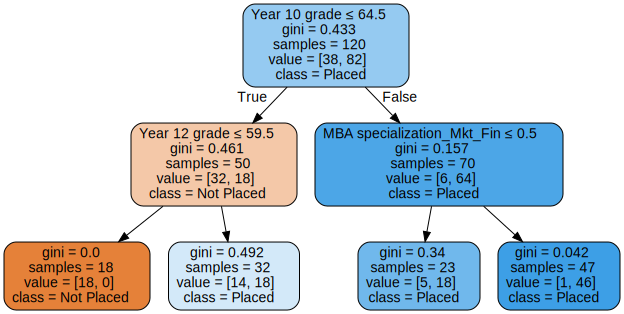

In [9]:
dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                     feature_names=x.columns, 
                     class_names=['Not Placed', 'Placed'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Each box in the tree above represents one group of the data.  The color of the group represents the average label.  In this case, blue is the "Placed" class, red is the "not Placed" class, and the intensity of the color representings the proportion in the majority class.  The class at the bottom is the majority class of the group.  If the group is not all one label, we ask a question of the group, which is the top line.  All of the data points that the condition is true for go to the left group, and all the ones it is false for go to the right group.  The other various numbers are statistics of the groups: how many points are in it, what the actual distribution of classes is, and the gini index (a measure of purity).

At each state, the decision tree asks the question that best reduces the uncertainty in predicting the labels.  So the first question we ask (the grade of a student from year 10) is the most feature in determining the label of a point.  We can see that after asking just this question, the two groups are pretty well separated.  The next question we ask is the best at reducing the uncertainty within a specific group.  As we can see above, this might be different for different branches of the tree.  Year 12 grade matters more for the group with a low Year 10 grade, whereas MBA specialization matters more for the other.  We can also see that reducing uncertainty is not the same thing as reducing *accuracy*.  For example, when asking for the MBA_specialization, the answer doesn't actually change the most likely label of a point.  It's "Placed" either way.  However, the answer does change how confident we can be with this answer.  After asking this question, we have a good chance of being nearly certain of the correct answer and a smaller chance of being less certain.

Looking at this model, we can see some of the more important features are the Year 10 Grade, Year 12 Grade, and MBA specialization.  We can also see whether they have a positive or negative effect on placement.  This is different than a neural network, where we would have very little idea of what our model is doing once it's trained.  Also, it's a little different than logistic regression too.  Not only do we see the relevant features and how the affect placement, but we also see how they interact!  For example, the MBA specialization seems to be less important for students who didn't do as well in Year 10.

Our accuracy for this model is 73% on validation.  We can do better by increasing the max depth of the model.  This also makes the model harder to interpret, though.  Let's take a look.

In [10]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=8)

clf.fit(x_train,y_train)

print(f'Train accuracy: {np.sum(y_train==clf.predict(x_train))/y_train.shape[0]}')
print(f'Validation accuracy: {np.sum(y_val==clf.predict(x_val))/y_val.shape[0]}')

Train accuracy: 1.0
Validation accuracy: 0.8292682926829268


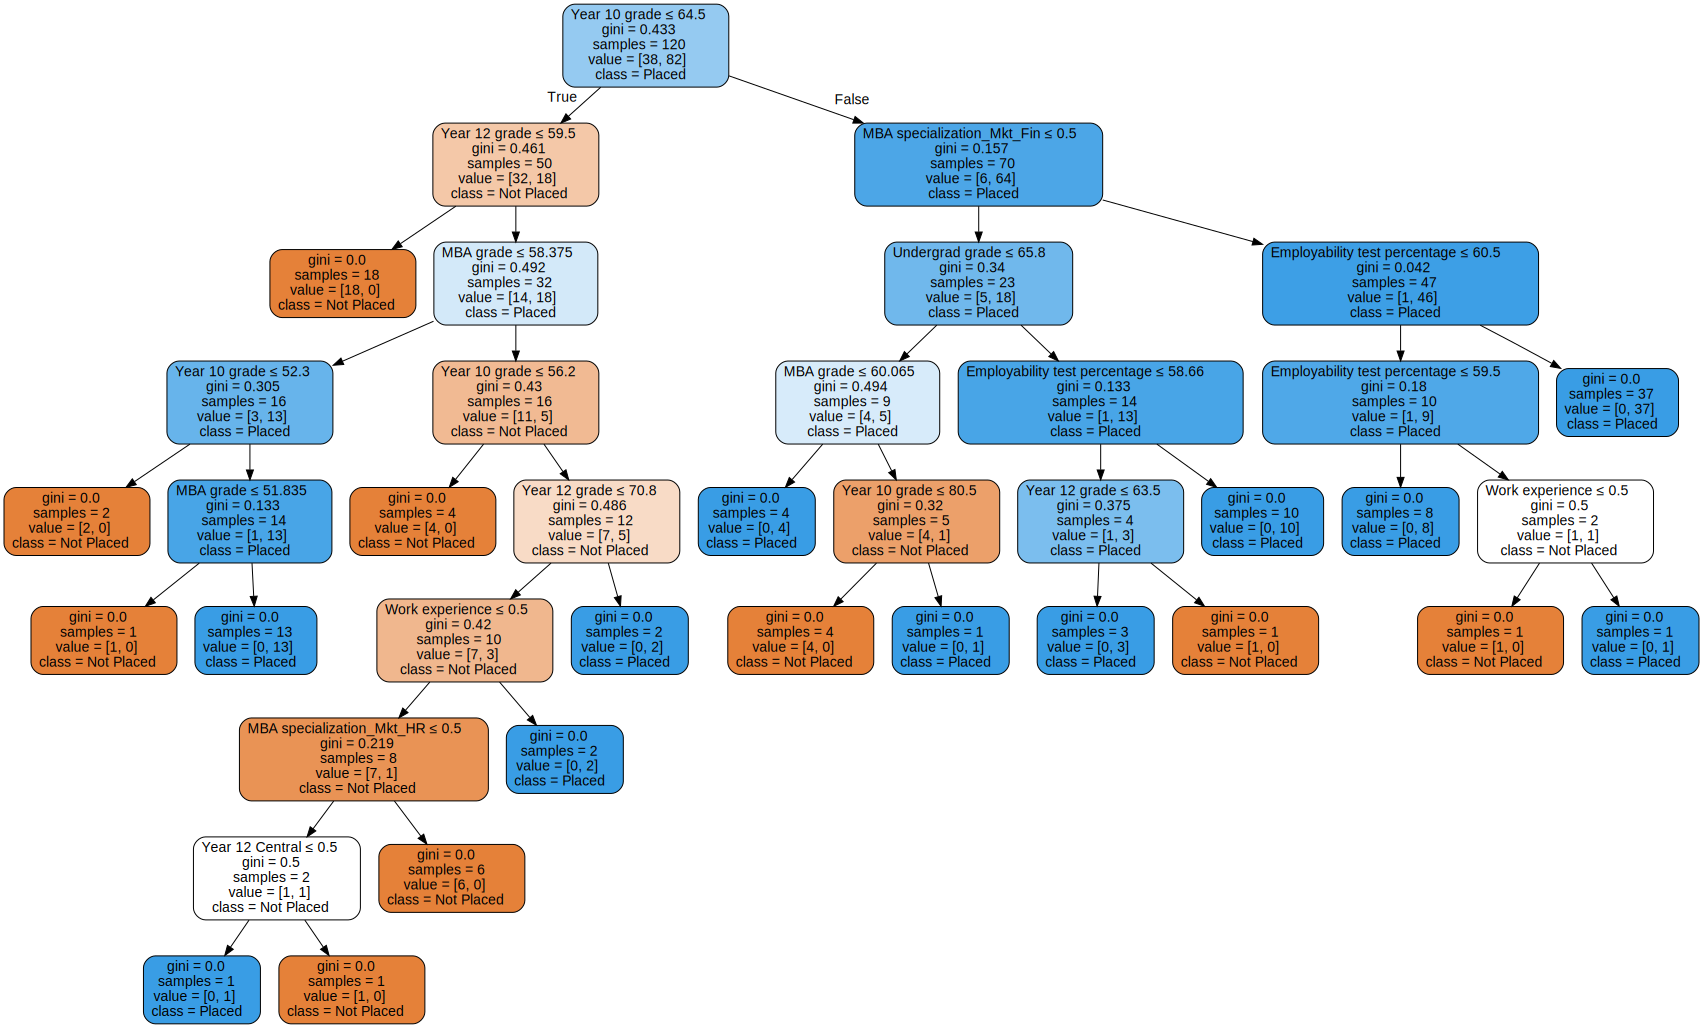

In [11]:
dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                     feature_names=x.columns, 
                     class_names=['Not Placed', 'Placed'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

This model is much more accurate, however, it is a little unweildly.  The image of the tree doesn't even fit on screen all at once!  (At least, it doesn't on mine.)  As we go towards the middle or the bottom of the tree, it becomes hard to understand how exactly all the different factors that come in to play interact.  Also, as our groups get smaller and smaller, we are more likely to be separating data based on meaningless and spurious patterns in the data than any significant trend in the data.

That being said, see how the top two levels in the model are actually the same as the first one?  This isn't a coincidence!  So even for a deep tree, we can look at the top few levels to get a simpler, less accurate model.

Is there an easy way to understand large decision trees?  Yes!  We can look at the importance scores, `DecisionTreeClassifier.feature_importances_`:

In [12]:
pd.DataFrame({'feature': x.columns, 'importance': clf.feature_importances_})

feature  importance
0                            gender    0.000000
1                     Year 10 grade    0.454071
2                   Year 10 Central    0.000000
3                     Year 12 grade    0.200706
4                   Year 12 Central    0.019255
5                   Undergrad grade    0.029355
6                   Work experience    0.066431
7     Employability test percentage    0.025313
8                         MBA grade    0.167553
9       Year 12 specialization_Arts    0.000000
10  Year 12 specialization_Commerce    0.000000
11   Year 12 specialization_Science    0.000000
12  Degree specialization_Comm_Mgmt    0.000000
13     Degree specialization_Others    0.000000
14   Degree specialization_Sci_Tech    0.000000
15       MBA specialization_Mkt_Fin    0.022873
16        MBA specialization_Mkt_HR    0.014442

This gives a score of how important each feature is in classifying.  Features used more and used closer to the top are rated as more important than others.  We can see here that the Year 10 Grade feature is the most important feature, as we expected.  Unlike logistic regression, these importance scores are all positive.  We can't determine whether a feature has a positive or negative effect based on its importance score.  In fact, it might have a more complicated!  (For example, too high or too low is a negative, but in the middle is a positive.)

We get 83% accuracy on the validation set in this model.  Can we do better?  Well, there's really only one parameter in the model we can change, which is `max_depth` (there are other parameters, but most do similar things).  There's also a little bit of randomness built into making these model.  If you play around with it, you'll probably find that (at least for our initial validation set) we can't get better than 87% accuracy on validation set and even then only when we get lucky.  So should we just call it quits?

The answer, of course, is no!  We can use a related model, a Random Forest Classifier.

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train, y_train)

print(f'Train accuracy: {np.sum(y_train==clf.predict(x_train))/y_train.shape[0]}')
print(f'Validation accuracy: {np.sum(y_val==clf.predict(x_val))/y_val.shape[0]}')

Train accuracy: 1.0
Validation accuracy: 0.9024390243902439


We get 90% accuracy here!  Again, there's some randomness in the model.  If we keep running, the score fluctuates, but it bottoms out at 87% accuracy which looked to be the top for our previous model.

So how exactly do random forests work?

Essentialy, random forests are just a collection of decision trees.  Each random tree is trained on only a portion of the training set as opposed to the entirety of it.  Then all these trees are used on each point and the predicted class for each point is whatever the majority says!  This ensures that irrelevant patterns used to fully separate the training set doesn't end up hurting our accuracy when we try to generalize.

This is great!  We get better accuracy.  Unfortunately, these are harder to interpret.  One thing we can do is just take a look at one of the decision trees in the random forest.

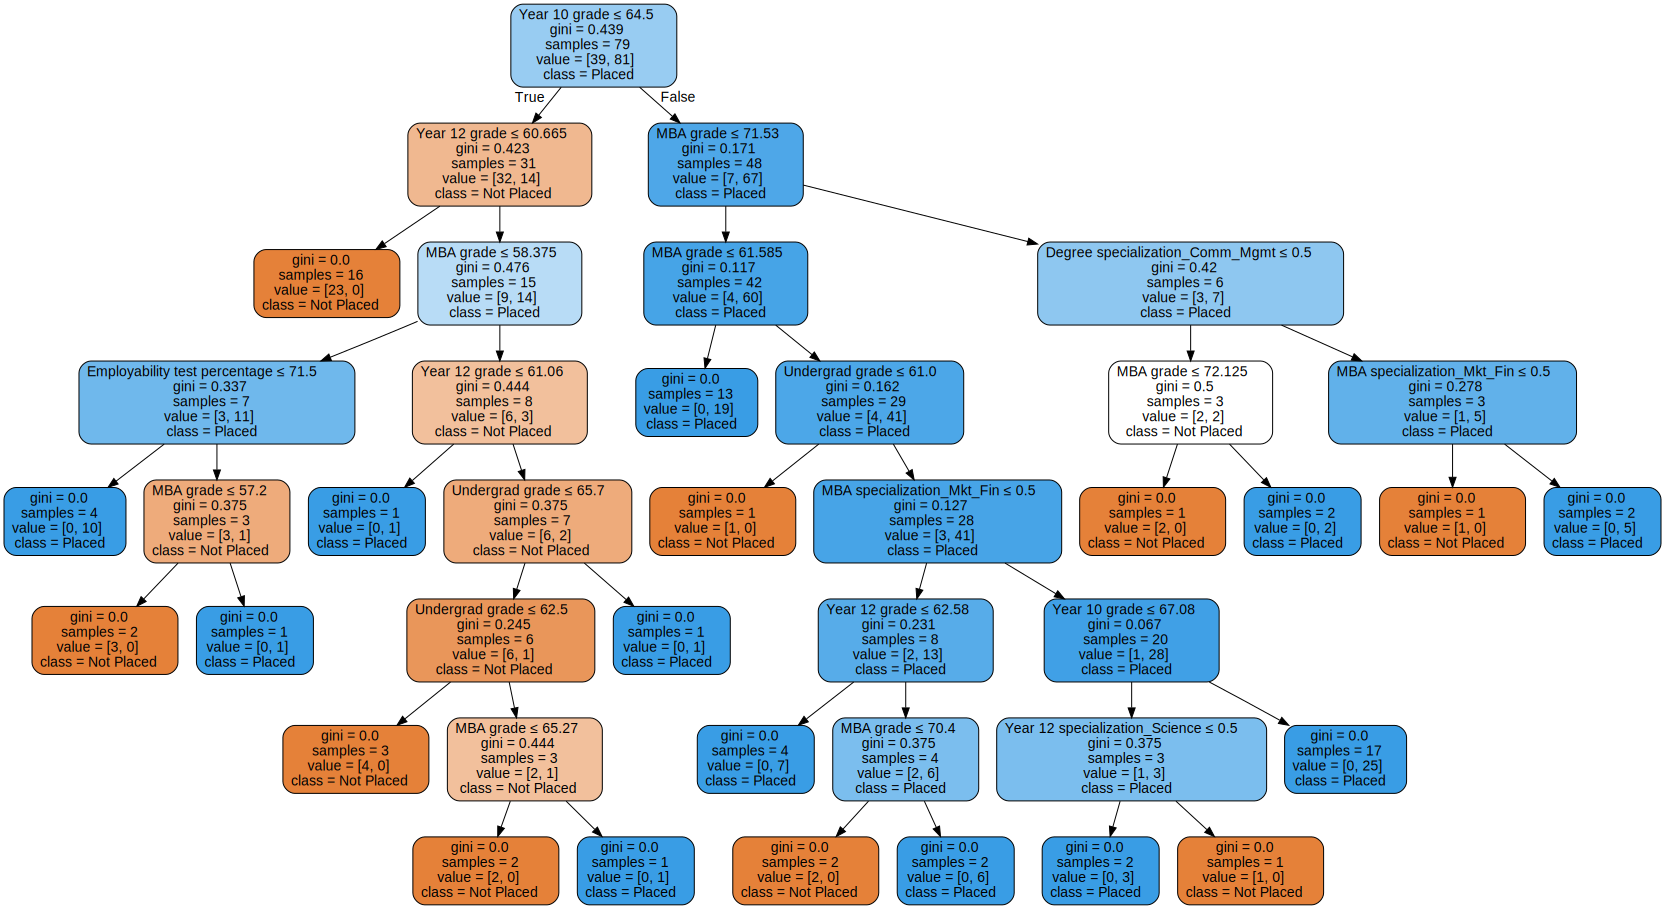

In [14]:
dot_data = sklearn.tree.export_graphviz(clf.estimators_[0], out_file=None, 
                     feature_names=x.columns, 
                     class_names=['Not Placed', 'Placed'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

This first one doesn't actually look all that different than our decision tree from before!  What if we looked at another?

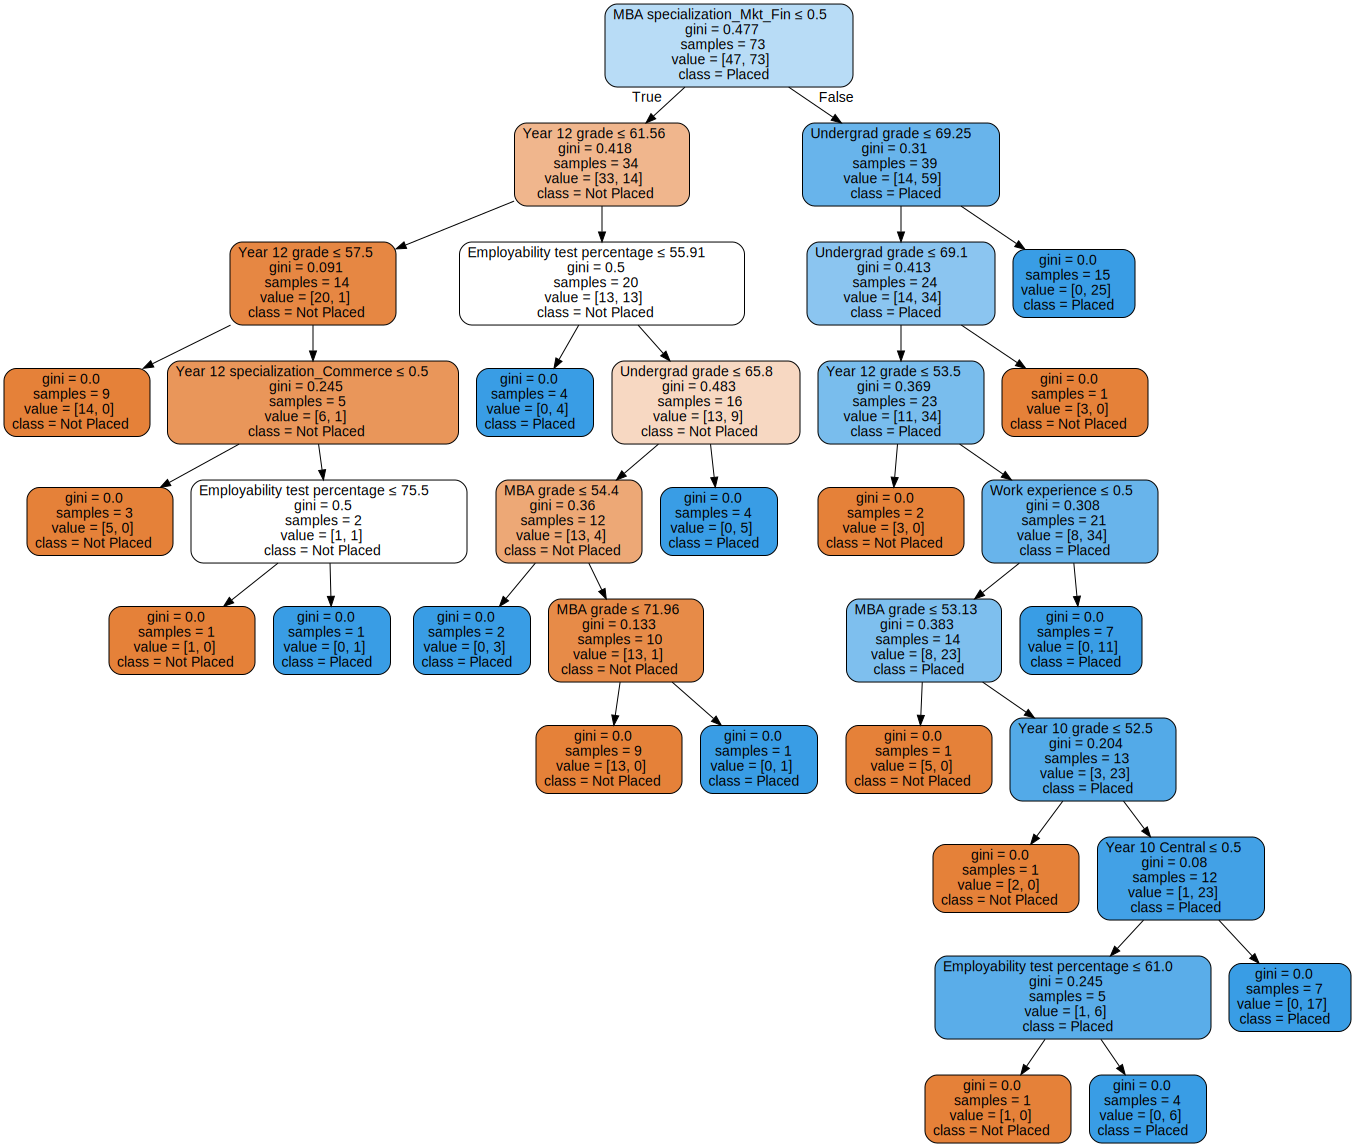

In [15]:
dot_data = sklearn.tree.export_graphviz(clf.estimators_[5], out_file=None, 
                     feature_names=x.columns, 
                     class_names=['Not Placed', 'Placed'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Hmm... this one is pretty different.  It's not even clear this is doing the same thing as the first one.  It might not be!  That's one disadvantage of random forests: we lose the easy interpretability of decision trees.  One thing we do keep is the importance score though!

In [16]:
pd.DataFrame({'feature': x.columns, 'importance': clf.feature_importances_})

feature  importance
0                            gender    0.019086
1                     Year 10 grade    0.250217
2                   Year 10 Central    0.016944
3                     Year 12 grade    0.129749
4                   Year 12 Central    0.012923
5                   Undergrad grade    0.195347
6                   Work experience    0.029119
7     Employability test percentage    0.075663
8                         MBA grade    0.112983
9       Year 12 specialization_Arts    0.002236
10  Year 12 specialization_Commerce    0.009457
11   Year 12 specialization_Science    0.007800
12  Degree specialization_Comm_Mgmt    0.011820
13     Degree specialization_Others    0.007961
14   Degree specialization_Sci_Tech    0.012109
15       MBA specialization_Mkt_Fin    0.048736
16        MBA specialization_Mkt_HR    0.057849

This is a combination of the importance scores of the various decision trees in the model.  We can see it looks pretty similar to the original decision tree we had, although it isn't exactly the same.  Again, these scores don't tell us what sort of effect a feature has on the classification, only how strong of an effect!  Looking at a decision tree in the model can help, but we can only get so far.  A feature could have a positive effect in one model and a negative effect in another model!  That being said, this is still a better measure than can usually be obtained with models such as neural networks.